# Курсовой проект

## Постановка задачи 

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Подключение библиотек и скриптов

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import catboost as catb
import lightgbm as lgbm
import xgboost as xgb


import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Пути к директориям и файлам

In [2]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
TARGET_NAME = 'Credit Default'

train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

In [3]:
train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
train.shape

(7500, 17)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [6]:
train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

<AxesSubplot:>

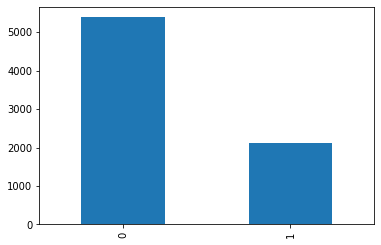

In [7]:
train['Credit Default'].value_counts().plot(kind='bar')

Видно что целевая фича имеет небольшой дисбаланс

In [8]:
train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [9]:
test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [10]:
test.shape

(2500, 16)

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

### Анализ пропусков и выбросов

Напишем дополнительные классы и методы

In [12]:
class ControllerPrepare:
    def __init__(self):
        self.default_Annual_Income = None
        self.default_Maximum_Open_Credit = None
        self.default_Years_in_current_job = None
        self.out_quan_Annual_Income = None
        self.out_quan_Maximum_Open_Credit = None
        self.Bankruptcies = None
        self.mean_Credit_Score = None
        self.out_quan_Credit_Score = None
        
    
    def get_info_from_train(self, df):
        #получаем среднее значение без выбросов
        self.default_Annual_Income = df['Annual Income'].mean()
        self.default_Maximum_Open_Credit = df['Maximum Open Credit'].mean()
        self.default_Years_in_current_job = df['Years in current job'].mode()[0]
        self.out_quan_Annual_Income = df['Annual Income'].quantile(0.995)
        self.out_quan_Maximum_Open_Credit = df['Maximum Open Credit'].quantile(0.995)
        self.Bankruptcies = df['Bankruptcies'].mode()[0]
        self.mean_Credit_Score = df['Credit Score'].mean()
        self.out_quan_Credit_Score = df['Credit Score'].quantile(0.995)
        
        return df
    
    def prepare(self, df):
        df = self.to_hot_cat(df)
        df = self.fillna_Annual_Income(df)
        df = self.fillna_Maximum_Open_Credit(df)
        df = self.fillna_Years_in_current_job(df)
        df = self.filna_Bankruptcies(df)
        df = self.fillna_Credit_Score(df)
        return df
    
    def to_hot_cat(self, df):
        df['Tax Liens'] = df['Tax Liens'].astype('int32')
        col_to_cat = ['Home Ownership', 'Tax Liens','Term', 'Purpose']
        for column_name in col_to_cat:
            df[column_name] = df[column_name].astype('category')
        return df
    
    def fillna_Annual_Income(self, df):
        df['Annual Income'] = df['Annual Income'].fillna(self.default_Annual_Income)
        df.loc[df['Annual Income'] > self.out_quan_Annual_Income, 'Annual Income'] = self.default_Annual_Income 
        return df
    
    def fillna_Maximum_Open_Credit(self, df):
        df['Maximum Open Credit'] = df['Maximum Open Credit'].fillna(self.default_Maximum_Open_Credit)
        df.loc[df['Maximum Open Credit'] > self.out_quan_Maximum_Open_Credit, 'Maximum Open Credit'] = self.default_Maximum_Open_Credit
        return df
    
    def fillna_Years_in_current_job(self, df):
        df['Years in current job'] = df['Years in current job'].fillna(self.default_Years_in_current_job)
        df['Years in current job'] = df['Years in current job'].astype('category')
        return df
    
    def filna_Bankruptcies(self,df):
        df['Bankruptcies'] = df['Bankruptcies'].fillna(self.Bankruptcies)
        return df
    
    def fillna_Credit_Score(self, df):
        df['Credit Score'] = df['Credit Score'].fillna(self.mean_Credit_Score)
        df.loc[df['Credit Score'] > self.out_quan_Credit_Score, 'Credit Score'] = self.mean_Credit_Score
        return df
    
    def get_and_prepare(self, df):
        self.get_info_from_train(df)
        self.prepare(df)
        return df
        
    def normalize(self, df, feats):
        scaler = StandardScaler()

        df_norm = df.copy()
        df_norm[feats] = scaler.fit_transform(df_norm[feats])

        return df_norm.copy()
    
def info_dataset(df, name_dataset):
    spam = ''
    print(f'Dataset:{name_dataset}')
    print(f'Название {spam:21}|Всего |Null-значений |Уникальных значений |Тип')
    for column_name in df.columns:
        all_count =  len(df[column_name])
        null_count = sum(df[column_name].isnull())
        unique_count = df[column_name].unique().size
        print(f'{column_name:30}|{all_count:6}|{null_count:14}|{unique_count:20}|{df[column_name].dtype}')
    print('-'*100)
    
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)



cprepare = ControllerPrepare()

In [13]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [14]:
info_dataset(train, 'train')
info_dataset(test, 'test')

Dataset:train
Название                      |Всего |Null-значений |Уникальных значений |Тип
Home Ownership                |  7500|             0|                   4|object
Annual Income                 |  7500|          1557|                5479|float64
Years in current job          |  7500|           371|                  12|object
Tax Liens                     |  7500|             0|                   8|float64
Number of Open Accounts       |  7500|             0|                  39|float64
Years of Credit History       |  7500|             0|                 408|float64
Maximum Open Credit           |  7500|             0|                6963|float64
Number of Credit Problems     |  7500|             0|                   8|float64
Months since last delinquent  |  7500|          4081|                  90|float64
Bankruptcies                  |  7500|            14|                   6|float64
Purpose                       |  7500|             0|                  15|object
Term     

### Категориальные признаки

К категориальным признакам исходя из описания, типа, количества и значений относятся однозначно:

* Home Ownership
* Tax Liens
* Purpose
* Term

In [15]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Tax Liens', 'Purpose', 'Term']

In [16]:
train['Tax Liens'] = train['Tax Liens'].astype('int32')
col_to_cat = ['Home Ownership', 'Tax Liens','Term', 'Purpose']
for column_name in col_to_cat:
    train[column_name] = train[column_name].astype('category')
    
train[CAT_FEATURE_NAMES].dtypes

Home Ownership    category
Tax Liens         category
Purpose           category
Term              category
dtype: object

### Числовые признаки 

#### Annual Income - годовой доход

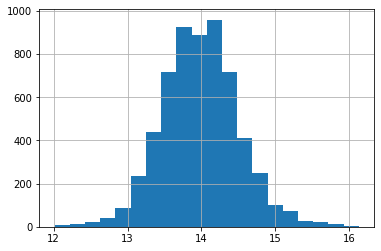

In [17]:
train[train['Annual Income'].notnull()]['Annual Income'].apply(np.log).hist(bins=20)
plt.show()

((array([-3.67998084, -3.44731998, -3.31922171, ...,  3.31922171,
          3.44731998,  3.67998084]),
  array([12.01125534, 12.0773582 , 12.08532209, ..., 16.00423735,
         16.04969689, 16.13291963])),
 (0.5213154415003349, 13.985768875812159, 0.9974228009115517))

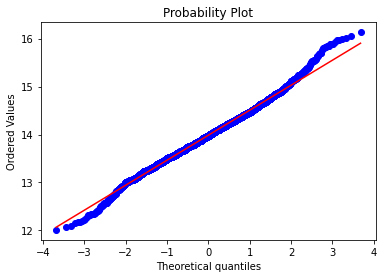

In [18]:
stats.probplot(train[train['Annual Income'].notnull()]['Annual Income'].apply(np.log), dist="norm", plot=plt)

Признак имеет выбросы и нулевые значение. Заменим их средним.

#### Years in current job - количество лет на текущем месте работы

In [19]:
train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

<AxesSubplot:xlabel='Years in current job', ylabel='count'>

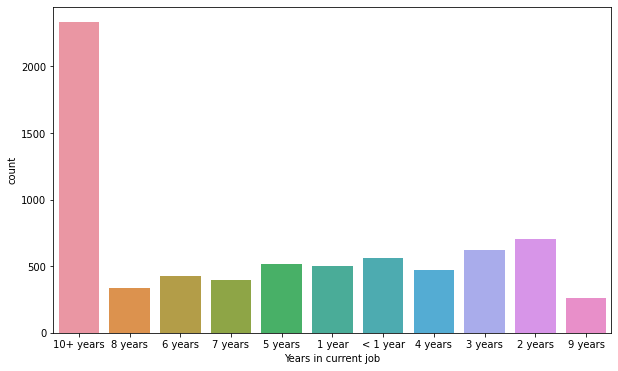

In [20]:
plt.figure(figsize=(10,6))
sns.countplot(train['Years in current job'])

Так же заменим пропуски средним значением

#### Maximum Open Credit - наибольший открытый кредит

In [21]:
train['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [22]:
dx = train[(np.abs(stats.zscore(train['Maximum Open Credit'])) > 3)]
print(dx.shape[0]/train.shape[0])

0.0005333333333333334


#### Months since last delinquent - количество месяцев с последней просрочки платежа

В данном признаке больше 50% пропусков. Удалим этот признак.

In [23]:
train.drop(columns = 'Months since last delinquent', axis=1, inplace=True)

#### Bankruptcies - банкротства

In [24]:
train.loc[ train[TARGET_NAME] == 1, 'Bankruptcies'].value_counts()

0.0    1878
1.0     217
2.0      11
3.0       2
4.0       1
Name: Bankruptcies, dtype: int64

In [25]:
train.loc[ train[TARGET_NAME] == 0, 'Bankruptcies'].value_counts()

0.0    4782
1.0     569
2.0      20
3.0       5
4.0       1
Name: Bankruptcies, dtype: int64

Заполняем пропуски наиболее частым значением.

#### Credit Score - кредитная оценка

In [26]:
train.loc[train['Credit Score'].isnull(), TARGET_NAME].value_counts()

0    1028
1     529
Name: Credit Default, dtype: int64

In [27]:
train['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

Числовой признак с пропусками и выбросами заполним их средним значением

In [28]:
train = cprepare.get_and_prepare(train)
info_dataset(train, 'train')

Dataset:train
Название                      |Всего |Null-значений |Уникальных значений |Тип
Home Ownership                |  7500|             0|                   4|category
Annual Income                 |  7500|             0|                5449|float64
Years in current job          |  7500|             0|                  11|category
Tax Liens                     |  7500|             0|                   8|category
Number of Open Accounts       |  7500|             0|                  39|float64
Years of Credit History       |  7500|             0|                 408|float64
Maximum Open Credit           |  7500|             0|                6926|float64
Number of Credit Problems     |  7500|             0|                   8|float64
Bankruptcies                  |  7500|             0|                   5|float64
Purpose                       |  7500|             0|                  15|category
Term                          |  7500|             0|                   2|category
C

#### Оценим корреляцию признаков:

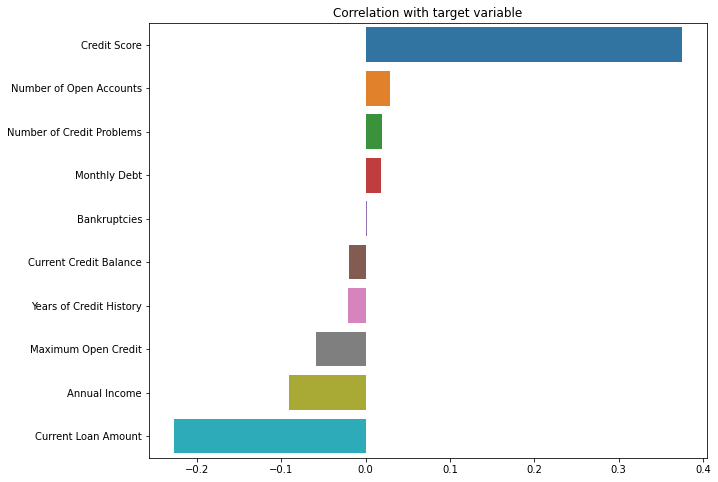

In [29]:
corr_with_target = train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

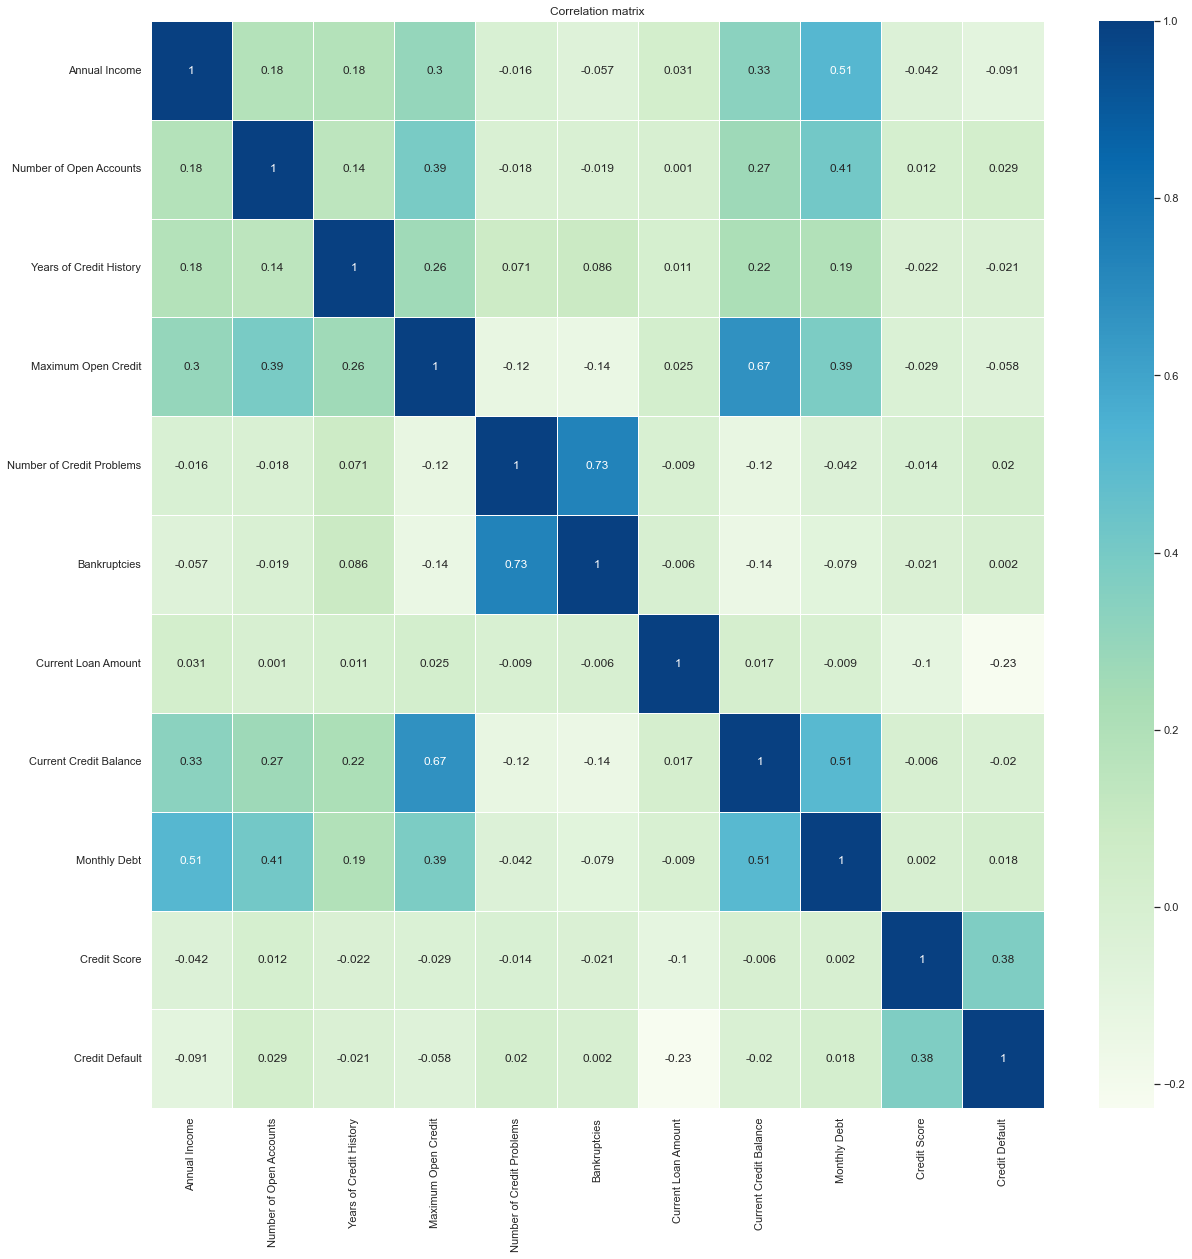

In [30]:
plt.figure(figsize = (20,20))

sns.set(font_scale=1)
sns.heatmap(train.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Есть значимая корреляция

* между Maximum Open Credit и Current Credit Balance
* Current Credit Balance и Monthly Debt
* Bankruptcies и Number of Credit Problems

#### Нормализация данных

In [31]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 
                     'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score'] 
CAT_FEATURE_NAMES = [train.columns.get_loc(col) for col in train.select_dtypes(include='category').columns]

In [32]:
train = cprepare.normalize(train,NUM_FEATURE_NAMES)

#### Разбиение на train и test

In [33]:
FEATURE_NAMES_SELECTED = train.columns.drop(TARGET_NAME)

In [34]:
X = train[FEATURE_NAMES_SELECTED]
y = train[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

#### Балансировка классов

In [35]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_for_balancing[TARGET_NAME].value_counts()

0    4074
1    1551
Name: Credit Default, dtype: int64

In [36]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
df_balanced[TARGET_NAME].value_counts()

0    4074
1    3102
Name: Credit Default, dtype: int64

In [37]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Home Ownership             7500 non-null   category
 1   Annual Income              7500 non-null   float64 
 2   Years in current job       7500 non-null   category
 3   Tax Liens                  7500 non-null   category
 4   Number of Open Accounts    7500 non-null   float64 
 5   Years of Credit History    7500 non-null   float64 
 6   Maximum Open Credit        7500 non-null   float64 
 7   Number of Credit Problems  7500 non-null   float64 
 8   Bankruptcies               7500 non-null   float64 
 9   Purpose                    7500 non-null   category
 10  Term                       7500 non-null   category
 11  Current Loan Amount        7500 non-null   float64 
 12  Current Credit Balance     7500 non-null   float64 
 13  Monthly Debt               7500 n

#### Подбор моделей

In [39]:
cat_feats = [X_train.columns.get_loc(col) for col in X_train.select_dtypes(include='category').columns]

In [40]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, cat_features=cat_feats)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4074
           1       0.90      0.79      0.84      3102

    accuracy                           0.87      7176
   macro avg       0.88      0.86      0.87      7176
weighted avg       0.88      0.87      0.87      7176

VALID

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1313
           1       0.57      0.47      0.52       562

    accuracy                           0.73      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1112  201
1                297  265
Wall time: 29.8 s


#### Выбор наилучшей модели, настройка гиперпараметров

In [41]:
params = {'n_estimators': [50, 100, 200, 300, 500, 1000],
          'max_depth': [3, 5, 7, 9]}
cv = KFold(n_splits=3, random_state=21, shuffle=True)

In [42]:
model = catb.CatBoostClassifier(class_weights=[1, 1.5], silent=True, random_state=21, cat_features=cat_feats)

In [43]:
%%time
rs = RandomizedSearchCV(model, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

Wall time: 1min 37s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000028A73F5AFD0>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [50, 100, 200, 300, 500,
                                                         1000]},
                   scoring='f1')

In [44]:
BEST_PARAMS = rs.best_params_
BEST_PARAMS = {'n_estimators': 300, 'max_depth': 9}
BEST_PARAMS

{'n_estimators': 300, 'max_depth': 9}

In [45]:
rs.best_score_

0.7391078431582084

#### Снижение степени переобучения

In [47]:
L2_LEAF_REG = 100
ignored_features = ['Maximum Open Credit', 'Monthly Debt', 'Bankruptcies']
model = catb.CatBoostClassifier(l2_leaf_reg=L2_LEAF_REG, 
                                      ignored_features = ignored_features,
                                      n_estimators=BEST_PARAMS['n_estimators'], 
                                      max_depth=BEST_PARAMS['max_depth'],
                                      silent=True, 
                                      random_state=21, cat_features=cat_feats)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_valid_pred_probs = model.predict_proba(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.88      0.79      4074
           1       0.78      0.56      0.65      3102

    accuracy                           0.74      7176
   macro avg       0.75      0.72      0.72      7176
weighted avg       0.75      0.74      0.73      7176

VALID

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1313
           1       0.59      0.48      0.53       562

    accuracy                           0.74      1875
   macro avg       0.69      0.67      0.67      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1123  190
1                293  269


### Подбор оптимального размера выборки, кривая обучения

In [48]:
CLASS_WEIGHTS = [1,1.5]
model = catb.CatBoostClassifier(l2_leaf_reg=L2_LEAF_REG, 
                                n_estimators=BEST_PARAMS['n_estimators'], 
                                max_depth=BEST_PARAMS['max_depth'],
                                class_weights=CLASS_WEIGHTS,
                                ignored_features = ignored_features,
                                silent=True, 
                                random_state=21, cat_features=cat_feats)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_valid_pred_probs = model.predict_proba(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.68      0.74      4074
           1       0.65      0.79      0.71      3102

    accuracy                           0.73      7176
   macro avg       0.73      0.73      0.73      7176
weighted avg       0.74      0.73      0.73      7176

VALID

              precision    recall  f1-score   support

           0       0.84      0.63      0.72      1313
           1       0.45      0.71      0.55       562

    accuracy                           0.66      1875
   macro avg       0.64      0.67      0.64      1875
weighted avg       0.72      0.66      0.67      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               828  485
1               161  401


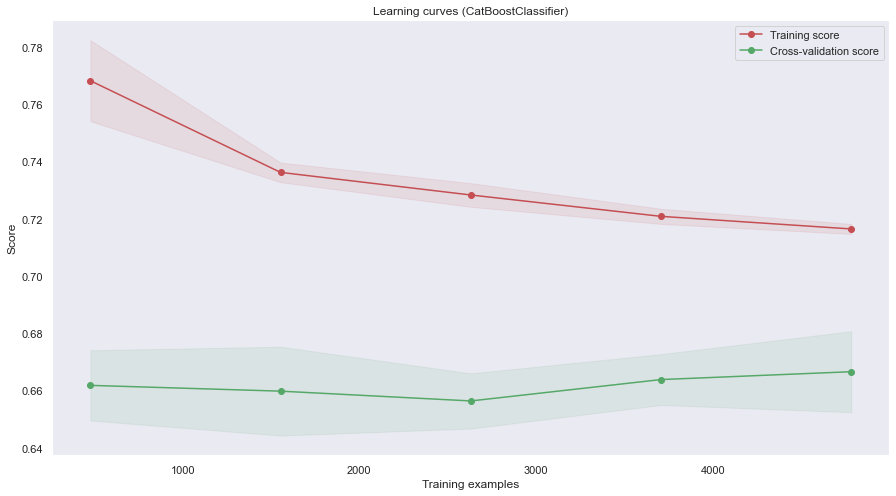

In [49]:
show_learning_curve_plot(model, X_train , y_train)

### Выбор порога вероятности для определения класса

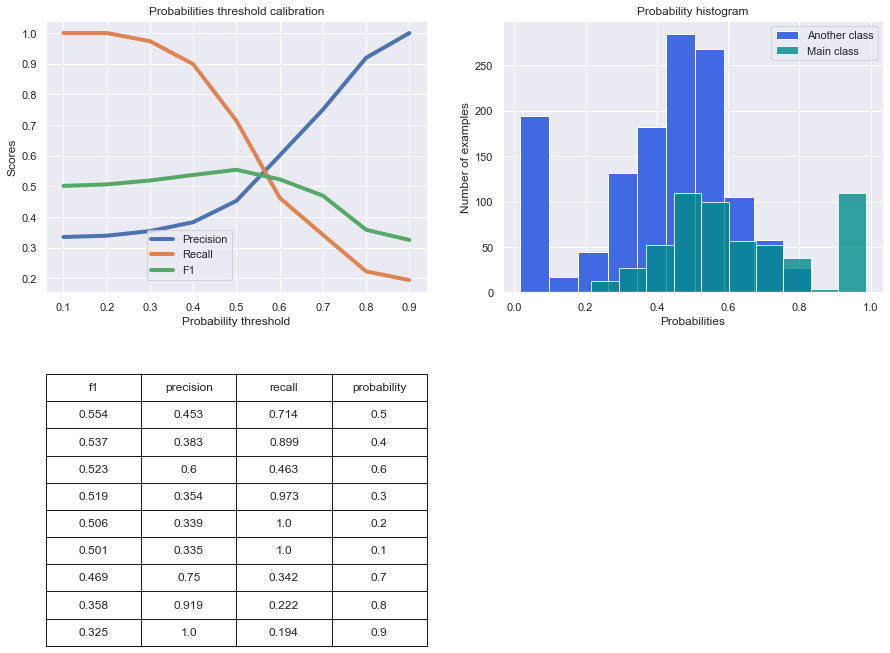

In [50]:
show_proba_calibration_plots(y_valid_pred_probs[:, 1], y_valid)

In [56]:
PROPOBILITY = 0.5

### Важность признаков

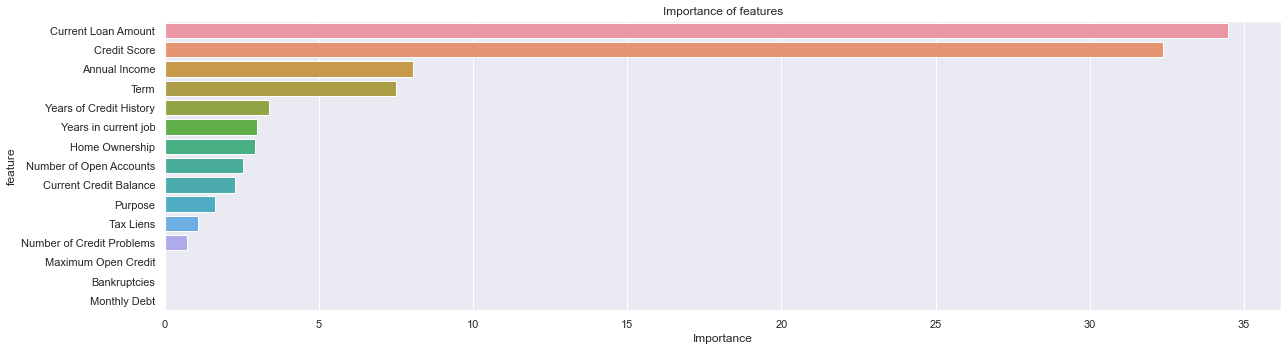

In [57]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=15)

In [58]:
FINAL_CAT_FEATS = []
for feat in important_features_top:
    print(f'{feat}:{X_train[feat].dtype}')
    if X_train[feat].dtype.name == 'category':
            FINAL_CAT_FEATS.append(feat)
for feat in ignored_features.copy():
    if feat not in important_features_top:
        ignored_features.remove(feat)

Current Loan Amount:float64
Credit Score:float64
Annual Income:float64
Term:category
Years of Credit History:float64
Years in current job:category
Home Ownership:category
Number of Open Accounts:float64
Current Credit Balance:float64
Purpose:category
Tax Liens:category
Number of Credit Problems:float64
Maximum Open Credit:float64
Bankruptcies:float64
Monthly Debt:float64


In [59]:
def bin_class_from_proba(y_valid_pred_probs):
    dx = pd.DataFrame(y_valid_pred_probs)
    dx[dx[1]>=PROPOBILITY] = 1
    dx[dx[1]<PROPOBILITY] = 0
    return dx[1].astype(int)

In [60]:
final_model = catb.CatBoostClassifier(l2_leaf_reg=L2_LEAF_REG,
                                n_estimators=BEST_PARAMS['n_estimators'], 
                                max_depth=BEST_PARAMS['max_depth'],
                                silent=True, 
                                class_weights=CLASS_WEIGHTS,
                                ignored_features = ignored_features,
                                random_state=21, cat_features=FINAL_CAT_FEATS)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_valid_pred_probs = final_model.predict_proba(X_valid[important_features_top])
y_valid_pred = bin_class_from_proba(y_valid_pred_probs)
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.68      0.74      4074
           1       0.65      0.80      0.72      3102

    accuracy                           0.73      7176
   macro avg       0.73      0.74      0.73      7176
weighted avg       0.75      0.73      0.73      7176

VALID

              precision    recall  f1-score   support

           0       0.83      0.62      0.71      1313
           1       0.45      0.71      0.55       562

    accuracy                           0.65      1875
   macro avg       0.64      0.67      0.63      1875
weighted avg       0.72      0.65      0.66      1875

CONFUSION MATRIX

1                 0    1
Credit Default          
0               189  163
1                80   75


In [61]:
test = cprepare.prepare(test)
test = cprepare.normalize(test, NUM_FEATURE_NAMES)

In [62]:
test_predict = bin_class_from_proba(final_model.predict_proba(test[important_features_top]))
final_df = pd.DataFrame({'Id':range(7500, 10000),TARGET_NAME:test_predict.astype(int)})
final_df.to_csv('Sgibnev_cours_project.csv', index=False)
final_df[TARGET_NAME].value_counts()

1    1288
0    1212
Name: Credit Default, dtype: int64